# Exploring r/redpillwomen submisions and comments

## Libraries & Setup

### Install

In [1]:
%pip install pandas numpy==1.24 matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install bertopic #[spacy]

Note: you may need to restart the kernel to use updated packages.


In [4]:
# %pip install NewsSentiment

In [5]:
%pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.


### Imports

In [6]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [7]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/.venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/.venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tilmankerl/Documents/

### General configs

In [8]:
# matplotlib theme
plt.style.use('ggplot')

### Data loading

In [9]:
# get DATA_DIR
DATA_DIR = os.path.join(Path(os.path.abspath("")).parent, "data")
print(DATA_DIR)

/Users/tilmankerl/Documents/UNI/SICSS/reddit-pills/data


In [10]:
submission_redpill = pd.read_csv(
    f"{DATA_DIR}/output/RedPillWomen_submissions.csv",
    names=["score", "date", "title", 'author_flair_text','link_flair_text','locked','over_18', "author","link", "body"]
)
comments_redpill = pd.read_csv(
    f"{DATA_DIR}/output/RedPillWomen_comments.csv",
    names=["score", "date", "is_submitter", "author","link", "body"]
)

In [11]:
# feature types
submission_redpill.date = pd.to_datetime(submission_redpill.date)
comments_redpill.date = pd.to_datetime(comments_redpill.date)

# introduce month and year columns + month_year column
submission_redpill['month'] = submission_redpill.date.dt.month
submission_redpill['year'] = submission_redpill.date.dt.year
submission_redpill['month_year'] = submission_redpill.date.dt.to_period('M')

In [12]:
print(
    submission_redpill.date.min(),
    submission_redpill.date.max()
)

2013-06-17 00:00:00 2022-12-31 00:00:00


## Exploration

### Submissions

We start our exploraiton by looking into NA values and duplicates.

In [13]:
submission_redpill.head()

,score,date,title,author_flair_text,link_flair_text,locked,over_18,author,link,body,month,year,month_year
0,1,2013-06-18,What's the point of this sub?,NaN,NaN,False,False,u/ienjoyzaandda,https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06
1,1,2013-06-17,What do you ladies feed your hamsters?,NaN,NaN,False,False,u/lauratheredditor,https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06
2,2,2013-06-17,How can I get ugly betas to pay for my things ...,NaN,NaN,False,False,u/[deleted],https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06
3,8,2013-06-17,Suggested Reading List?,Endorsed Woman,NaN,False,False,u/margerym,https://www.reddit.com/r/RedPillWomen/comments...,(I'm new to reddit and the Red Pill community ...,6,2013,2013-06
4,7,2013-06-17,Best way to Convince Man He's the Father?,NaN,NaN,False,False,u/Dramatological,https://www.reddit.com/r/RedPillWomen/comments...,NaN,6,2013,2013-06


In [14]:
# get NAs
submission_redpill.isna().sum()

score                    0
date                     0
title                    0
author_flair_text    20380
link_flair_text      10839
locked                   0
over_18                  0
author                   0
link                     0
body                  1396
month                    0
year                     0
month_year               0
dtype: int64

Plot avergae length of body text

Text(0.5, 1.0, 'Distribution of body text length for submissions')

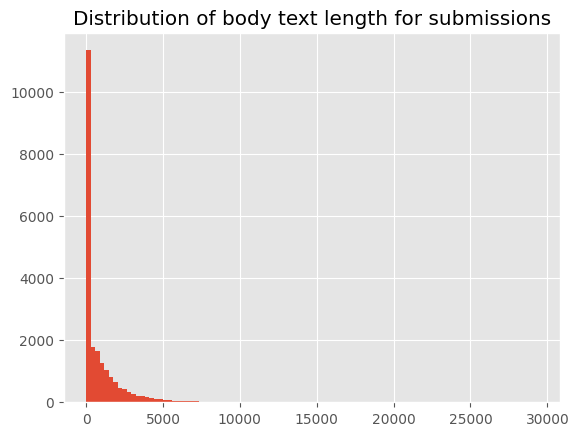

In [15]:
submission_redpill.body.str.len().hist(
    bins=100    
).set_title("Distribution of body text length for submissions")

Plot posts over time:

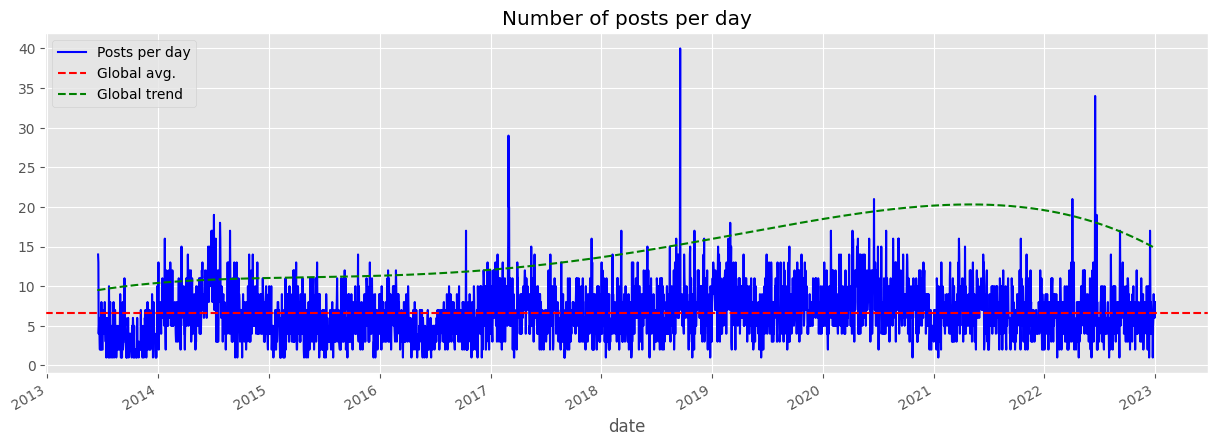

In [16]:
#Plot posts over time:
submission_redpill.date.value_counts().sort_index().plot(
    kind='line',
    title="Number of posts per day",
    figsize=(15, 5),
    # color
    color='b',
)

# add average line
plt.axhline(submission_redpill.date.value_counts().mean(), color='r', linestyle='--')

# convert date to ordinal
submission_redpill['date_ordinal'] = pd.to_datetime(submission_redpill['date']).apply(lambda date: date.toordinal())

# add trend line
z = np.polyfit(submission_redpill['date_ordinal'], submission_redpill['score'], 10)
p = np.poly1d(z)
plt.plot(submission_redpill['date'],p(submission_redpill['date_ordinal']),"g--")

# add legend
plt.legend(['Posts per day', 'Global avg.', 'Global trend'])

Get date with 3-highest number of posts for manual inspection

In [17]:
submission_redpill.groupby('date').count().sort_values(by='author', ascending=False).head(3)

,score,title,author_flair_text,link_flair_text,locked,over_18,author,link,body,month,year,month_year,date_ordinal
date,,,,,,,,,,,,,
2018-09-18,40,40,4,21,40,40,40,40,39,40,40,40,40
2022-06-17,34,34,0,28,34,34,34,34,34,34,34,34,34
2017-03-01,29,29,1,4,29,29,29,29,29,29,29,29,29


Get deleted posts

In [18]:
submission_redpill.body.str.contains('\[deleted\]|\[removed\]').sum()

9136

### Comments

In [19]:
comments_redpill.head()

,score,date,is_submitter,author,link,body
0,2,2017-10-01,False,u/etf42,https://www.reddit.com/r/RedPillWomen/comments...,Men have always been more disposable due to th...
1,1,2017-10-01,False,u/throwawayklutch,https://www.reddit.com/r/RedPillWomen/comments...,"To me, these women seem like they just have no..."
2,2,2017-10-01,False,u/SouthernAthena,https://www.reddit.com/r/RedPillWomen/comments...,That attitude will get them far in life. But y...
3,8,2017-10-01,False,u/platewrecked,https://www.reddit.com/r/RedPillWomen/comments...,"Greg the OP is a suicidal, drug addled, datele..."
4,2,2017-10-01,False,u/thelampshade25,https://www.reddit.com/r/RedPillWomen/comments...,Very funny video i was loling the whole time


Inspecting NAs & drop them

In [20]:
print(comments_redpill.isna().sum())
comments_redpill = comments_redpill.dropna()

score           0
date            0
is_submitter    0
author          0
link            0
body            4
dtype: int64


## Brief Topic modelling using BERTopic

Topic-specific preprocessing

In [21]:
submission_redpill_topic = submission_redpill.copy()

print("Before processing:")
print(submission_redpill_topic.shape)

# drop body NAs
submission_redpill_topic = submission_redpill_topic.dropna(subset=['body'])

# drop link duplicates
submission_redpill_topic = submission_redpill_topic.drop_duplicates(subset=['link'])

# remove double spaces & new lines from body
submission_redpill_topic['body'] = submission_redpill_topic['body'].str.replace('\n', ' ')
submission_redpill_topic['body'] = submission_redpill_topic['body'].str.replace('  ', ' ')

# intriduce doc_text column (concat title and body)
submission_redpill_topic['doc_text'] = submission_redpill_topic['title'] + ' ' + submission_redpill_topic['body']
# set dtype to string
submission_redpill_topic['doc_text'] = submission_redpill_topic['doc_text'].astype(str)

# remove delted and removed posts
# check if body is [deleted] or [removed] in one line
submission_redpill_topic = submission_redpill_topic[~submission_redpill_topic['body'].str.contains('\[deleted\]|\[removed\]')]

# based on quantiles, filter out the top and bottom 5% of doc_text length
top_quantile_value = submission_redpill_topic['doc_text'].str.len().quantile(0.95)
print(top_quantile_value)

bottom_quantile_value = submission_redpill_topic['doc_text'].str.len().quantile(0.05)
print(bottom_quantile_value)

# Filter the DataFrame to keep only rows with doc_text length below the 95th percentile
submission_redpill_topic = submission_redpill_topic[submission_redpill_topic['doc_text'].str.len() <= top_quantile_value]
submission_redpill_topic = submission_redpill_topic[submission_redpill_topic['doc_text'].str.len() >= bottom_quantile_value]

# drop duplicates in doc_text
submission_redpill_topic = submission_redpill_topic.drop_duplicates(subset=['doc_text'])

# remove links from doc_text
url_regex_1 = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
url_regex = r'(?:https?://)?(?:www\.)?[a-zA-Z0-9-]+\.[a-zA-Z]{2,}(?:/[^/\s]*)*'
submission_redpill_topic['doc_text'] = submission_redpill_topic['doc_text'].replace(url_regex, '', regex=True)


print("After processing:")
print(submission_redpill_topic.shape)

Before processing:
(22995, 14)
5152.0
128.0
After processing:
(10948, 15)


Checking if the url regex worked:

In [22]:
print(
    submission_redpill_topic.doc_text.str.contains(url_regex).sum(),
    submission_redpill_topic.doc_text.str.contains("http").sum()
)

0 10


Text(0.5, 1.0, 'Distribution of doc-text length for submissions')

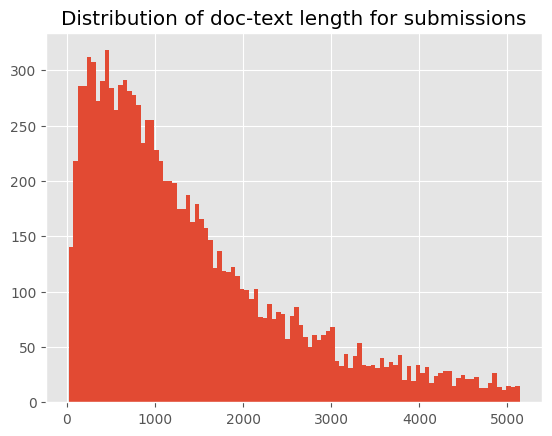

In [23]:
submission_redpill_topic.doc_text.str.len().hist(
    bins=100    
).set_title("Distribution of doc-text length for submissions")

Load all titles and bodies as one string in list (one string per post containing title and body)

In [24]:
# Load all titles and bodies as one string in list (one string per post containing title and body)
topic_ready_docs = submission_redpill_topic['doc_text'].tolist()

In [25]:
print(topic_ready_docs[0])

Suggested Reading List? (I'm new to reddit and the Red Pill community so I'm not sure exactly how these things go. I've decided to just jump in. Apologies if I'm overstepping.) I'd love some book recommendations re: Red Pill theory/philosophy as well as the practical aspects of *living* it as a woman; married or otherwise.  As a side but related question: Though I am new to Red Pill itself I was first turned onto the more "old fashioned" way of doing things through Fascinating Womanhood and The Surrendered Wife. Any thoughts on how those two books do or don't relate with the philosophy? Thank you! Margery


In [26]:
representation_model = KeyBERTInspired() 
topic_model = BERTopic(representation_model=representation_model, nr_topics=20) # nr_topics="auto"

In [27]:
# takes 4.5 min for full
topic_model.fit(topic_ready_docs)

In [28]:
topic_model.get_topic_info()    # Get topic words and their probabilities

,Topic,Count,Name,Representation,Representative_Docs
0,0,10937,0_relationship_love_his_what,"[relationship, love, his, what, be, being, him...",[I’m getting a second chance at a relationship...
1,1,11,1_tarot_tuesday_readings_wednesday,"[tarot, tuesday, readings, wednesday, reading,...","[Tarot Tuesday: December Happy Tuesday, ladies..."


In [29]:
for doc in topic_model.get_representative_docs(19):
    print(doc)

TypeError: 'NoneType' object is not iterable

In [ ]:
topic_model.visualize_barchart()

In [ ]:
# submission_redpill_topic["date"].to_list()
topics_over_time_yearly = topic_model.topics_over_time(topic_ready_docs, submission_redpill_topic["year"].to_list())

In [ ]:
topics_over_time_monthly = topic_model.topics_over_time(topic_ready_docs, submission_redpill_topic["month_year"].to_list())

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time_yearly, topics=list(range(-1, 13)))

In [ ]:
monthly_df = topics_over_time_monthly[['Topic', 'Frequency', 'Timestamp']]
# make topic a column and the frequency the value of the cell
monthly_df = monthly_df.pivot(index='Timestamp', columns='Topic', values='Frequency')
monthly_df.fillna(0, inplace=True)

In [ ]:
monthly_df

In [ ]:
monthly_df.plot(
    kind="line",
    title="Monthly avg. topic mentions",
    xlabel="Date",
    ylabel="Avg. topic mentions",
    figsize=(20, 10),
    legend=True,
)